In [1]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widjets
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sys import stdout,getsizeof
from mpl_toolkits.mplot3d import Axes3D
from time import time
import pandas as pd
from sklearn.decomposition import PCA
np.set_printoptions(precision=2)
#np.random.seed(0)

In [2]:
class SOMNetwork():
    def __init__(self, x,y, dim, data, sigma=None, learning_rate=0.1, tau1=1000, tau2=1000, 
                 dtype=tf.float32,accuracy = 0.001, maptype='jejeje'):
        #np.random.seed(0)
        self.dtype = dtype
        self._X,self._Y = x,y
        self._X_ = tf.constant(x, dtype=tf.int32, name='MAP_width')
        self._Y_ = tf.constant(y, dtype=tf.int32, name='MAP_height')
        self.DATA = data
        _initial_map = self._PCA_init()
        self._DATA = tf.constant(data, dtype=self.dtype, name='DATA')
        self._map_weights = tf.Variable(_initial_map,dtype=self.dtype, name='weights')
        self.dim = tf.constant(dim, dtype=tf.int64)
        self._learning_rate = tf.constant(learning_rate, dtype=self.dtype, name='learning_rate')
        self._sigma = tf.constant(sigma, dtype=self.dtype, name='sigma')
        self._tau1 = tf.constant(tau1, dtype=self.dtype, name='tau_learn_rate')
        self._tau2 = tf.constant(tau2, dtype=self.dtype, name='tau_sigma')
        self._accuracy = accuracy
        self._input_num = tf.placeholder(dtype=tf.int32, name='input_num')
        self._num_iter = tf.placeholder(dtype=self.dtype, name='iteration')
        self._angles = tf.constant(np.pi * np.linspace(0,1,y)[:y],dtype=tf.float32)
        #self.positions = tf.reshape(tf.cast(tf.where(tf.fill([x, y], True)),dtype=self.dtype),[x,y,-1]) #полезно
        self.SOM_MAP = 1   #сохраняем карту сюда после сессии
        if maptype=='sphere':
            self._distance_map = tf.constant(self._Maptype_Sphere(self._X, self._Y),dtype=self.dtype)
        elif maptype=='toroidal':
            self._distance_map = tf.constant(self._Maptype_Torus(self._X, self._Y),dtype=self.dtype)
        else:
            self._distance_map = tf.constant(self.Get_Distances(y),dtype=self.dtype)
            #self._distance_map = tf.constant(self._dist_Torus(),dtype=self.dtype)
        self.FUNC_Q = tf.Variable(0,dtype=self.dtype,name = 'FUNCTIONAL_Q')
        self._X_bias = int(self._X/2)
        
    def change_params(self,sigma=6, learning_rate=0.1, tau1=1000, tau2=1000, init_map=None):
        self._sigma = tf.constant(sigma, dtype=self.dtype, name='sigma')
        self._learning_rate = tf.constant(learning_rate, dtype=self.dtype, name='learning_rate')
        self._tau1 = tf.constant(tau1, dtype=self.dtype, name='tau_learn_rate')
        self._tau2 = tf.constant(tau2, dtype=self.dtype, name='tau_sigma')
        if init_map:
            _initial_map = init_map
            self._map_weights = tf.Variable(_initial_map,dtype=self.dtype, name='weights')
    
        
    def _PCA_init(self):
        pca = PCA(n_components=2)
        pca.fit(self.DATA)  
        pcaVec=pca.components_
        x_lin = np.linspace(-1,1,self._X)
        y_lin = np.linspace(-1,1,self._Y)
        Weigths = []
        for i in range(self._X):
            for j in range(self._Y):
                Weigths.append(x_lin[i]*pcaVec[0] + x_lin[j]*pcaVec[1])
        return np.array(Weigths).reshape((self._Y,self._X,-1))
    
    def change_initial_map(self,_initial_map):
        self._map_weights = tf.Variable(_initial_map,dtype=self.dtype, name='weights')
        
    def _train(self):
        with tf.name_scope('cooperation') as scope:
            _current_learning_rate = tf.maximum(self._learning_rate*tf.exp(-self._num_iter/self._tau1), 0.1)
            _current_sigma = tf.maximum(self._sigma*tf.exp(-self._num_iter/self._tau2), 0.01)
            
            self._bmu_coords=self._won_neuron()
            bmu_distance = tf.roll(self._distance_map, shift=self._bmu_coords[0], axis=0)
            neighbourhood_func = tf.tile(tf.exp(-bmu_distance**2/(2*_current_sigma**2)), [1,self._X_])
            
            learning_rate_matrix = _current_learning_rate* neighbourhood_func
            _same_img_matr = tf.reshape(tf.tile(self._DATA[self._input_num], [self._X_]),[self._X_,99,99,1],name='reshape_img')
            _cur_angles = tf.roll(self._angles, shift=self._bmu_coords[1], axis=0)
            Matr_of_rotated = tf.reshape(tf.contrib.image.rotate(_same_img_matr,_cur_angles,interpolation='BILINEAR'),[self._X_,-1])
            
            delta = tf.transpose(tf.transpose(Matr_of_rotated -self._map_weights) *tf.transpose(learning_rate_matrix))
            #delta = tf.transpose(tf.transpose(self._DATA[self._input_num]-self._map_weights)*tf.transpose(learning_rate_matrix))
            
            new_weights = self._map_weights + delta
            training_op = tf.assign(self._map_weights, new_weights)
        return training_op
    
    def _won_neuron(self):
        distance = tf.norm(self._DATA[self._input_num] - self._map_weights,axis=-1)
        #distance = tf.reduce_sum(tf.square(self._input - self._map_weights), axis=-1)
        bmu=tf.argmin(tf.reshape(distance, [-1]))
        #bmu_location = self.positions[bmu]
        bmu_location = tf.unravel_index(bmu, [self._X_,self._Y_])
        return bmu_location
        
    def training(self,data_len, n_iters,Verbose=False,accuracy=None):
        self._sess = tf.Session()
        self._sess.run(tf.global_variables_initializer())
        
        #summary_writer = tf.summary.FileWriter('./logs/', tf.get_default_graph())
        #summary_op = tf.summary.scalar('Functional_Z', self.FUNCTIONAL_Z())
        #tf.summary.scalar('Functional_Q', self.FUNC_Q)
        #self._data = tf.constant(data,dtype=self.dtype, name='data')
        #self._data_len = tf.constant(len(data), dtype=self.dtype, name='data_length')
        #self._data_len = len(data)
        #summaries = tf.summary.merge_all()
        
        
        _training = self._train()
        _functional = self.FUNCTIONAL_Z()
        temp_funq = 0
        history = []
        self.funq_history=[]
        #with tf.Session() as sess:
        with self._sess.as_default():
            for i in range(n_iters):
                n_item = np.random.randint(data_len)
                #n_item = i % (len(data)-1)
                self._sess.run(_training, feed_dict={self._input_num: n_item, self._num_iter:i})
                
                
                #idx = i % (len(data)-1)
                if i % 50 == 0:
                    #self.FUNCTIONAL_Q()
                    
                    new_funq=self._sess.run(_functional)
                    self.funq_history.append(new_funq)
                    #summary_writer.add_summary(self._sess.run(summary_op), i)
                    #summary_writer.add_summary(self._sess.run(summaries), i)
                    #new_funq=sess.run(_functional)
                    #if abs(temp_funq-new_funq)<self._accuracy: break
                    #temp_funq = np.copy(new_funq)
                    
                #history.append(self._map_weights.eval())
                    
                if Verbose:
                    _to_print = f'\r Iters = {i},n_item = {n_item}, funq = {new_funq}'
                    stdout.write(_to_print)
            self.SOM_MAP = self._map_weights.eval()
            self.history = history
        self._sess.close()
        return i, new_funq
            
    
    def check_for_nodes(self,data):
        def WIN_NEURON(vect):
            distances=np.linalg.norm(self.SOM_MAP-vect,axis=-1)
            index=np.argmin(distances)
            return index
        #for i in range(len(data)):
        for vect in data:
            a=WIN_NEURON(vect)
            print(a)
    
    def _Maptype_Sphere(self,A,B):
        thetta = np.linspace(0,np.pi,A)
        phi = np.linspace(0,2*np.pi,B+1)[:B]
        #THETTA, PHI = np.meshgrid(thetta, phi)
        PHI,THETTA = np.meshgrid(phi,thetta)
        THETTA = THETTA.reshape(-1)
        PHI = PHI.reshape(-1)
        x = np.sin(THETTA)*np.cos(PHI)
        y = np.sin(THETTA)*np.sin(PHI)
        z = np.cos(THETTA)
        sphere = np.vstack((x,y,z)).T
        return sphere.reshape(A,B,-1)
    
    def _Maptype_Torus(self,A,B):
        theta = np.linspace(0, 2.*np.pi, A+1)[:A]
        phi   = np.linspace(0, 2.*np.pi, B+1)[:B]
        theta, phi = np.meshgrid(theta, phi)
        theta = theta.reshape(-1)
        phi = phi.reshape(-1)
        R0, a = 0.7, 0.3
        x = (R0 + a*np.cos(theta)) * np.cos(phi)
        y = (R0 + a*np.cos(theta)) * np.sin(phi)
        z = a * np.sin(theta)
        Torus = np.vstack((x,y,z)).T
        return Torus.reshape(A,B,-1)
    
    def _dist_Torus(self):
        TOR = self._Maptype_Torus(self._X,self._Y)
        a=np.linalg.norm(TOR-TOR[0,0],axis=-1)
        return a
    
    def Get_Distances(self,y):
        def ring_closure(A):
            if A==1: return [0]
            a=np.arange(A)
            max_val = int(len(a)/2)
            max_ind=np.argwhere(a==max_val)[0,0]
            if len(a)%2==0:
                b=np.arange(1,a[max_ind])[::-1]
            else:
                b=np.arange(1,a[max_ind+1])[::-1]
            a[max_ind+1:]=b
            return a
        res=ring_closure(y).reshape(y,1)
        return res
    
    
    def FUNCTIONAL_Z(self):
        #ATTENTION! Working only for 2D maps
        #Functional_Z = 0
        B=tf.roll(self._map_weights, shift=1, axis=0)
        F1 = tf.reduce_sum(tf.norm(tf.subtract(self._map_weights,B),axis=-1))
        B=tf.roll(self._map_weights, shift=1, axis=1)
        F2 = tf.reduce_sum(tf.norm(tf.subtract(self._map_weights,B),axis=-1))
        return F1+F2
    
    
    def func_for_Q(self):
        bmu = self._won_neuron()
        dist = tf.norm(self._input-self._map_weights[bmu[0],bmu[1]], axis=0)
        return dist
    
    def FUNCTIONAL_Q1(self):
        FUNC = tf.Variable(0)
        init = tf.global_variables_initializer()
        with tf.Session() as sess:
            init.run()
            for i in range(len(DATA)):
                FUNC+=sess.run(self.func_for_Q(), feed_dict = {self._input:DATA[i]})
                
    def FUNCTIONAL_Q1(self):
        FUNC = tf.Variable(0,dtype=self.dtype)
        FUNC_op = tf.assign(FUNC, FUNC+self.func_for_Q())
        with self._sess.as_default():
            self._sess.run(FUNC.initializer)
            for i in range(len(DATA)):
                self._sess.run(FUNC_op, feed_dict = {self._input:DATA[i]})
                #FUNC += self._sess.run(self.func_for_Q(),feed_dict = {self._input:DATA[i]})
            #print(self._sess.run(FUNC))
            self._sess.run(tf.assign(self.FUNC_Q, FUNC))
        #return FUNC
    #def FUNCTIONAL_Q(self):
    #    #FUNC = tf.Variable(0,dtype=self.dtype)
    #    won_matrix = tf.stack( for i in range(self._data_len)])

In [7]:
DATA = np.load('cube100x100_60x60_2D_4.npy')
SOM = SOMNetwork(x=60,y=60,dim=len(DATA[0]),data=DATA, sigma=10,learning_rate=1,tau1=13000,tau2=7500,maptype='tordasd')

A=SOM._train()
#for i in range(bmu_distance.shape[0])
#t_div_sig=bmu_distance**2/SOM._sigma**2
#neighbourhood_func = tf.exp(-t_div_sig/2)*(1-t_div_sig)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    b = sess.run(A, feed_dict={SOM._input_num: 10, SOM._num_iter:1})
    print(b[0])

[1.   0.98 0.96 0.92 0.88 0.84 0.78 0.73 0.67 0.61 0.55 0.49 0.43 0.38
 0.32 0.28 0.24 0.2  0.16 0.14 0.11 0.09 0.07 0.06 0.04 0.03 0.03 0.02
 0.01 0.01 0.01 0.02 0.03 0.03 0.04 0.06 0.07 0.09 0.11 0.14 0.16 0.2
 0.24 0.28 0.32 0.38 0.43 0.49 0.55 0.61 0.67 0.73 0.78 0.84 0.88 0.92
 0.96 0.98 1.   1.  ]


In [3]:
#DATA = np.load('cube100x100_60x60_2D_4.npy')
#DATA = np.load('cube100x100_60x60_2D_6.npy')
#DATA = np.load('cube100x100_60x60_2D_non_simmetr.npy').reshape(3600,-1)
DATA = np.load('cube100x100_60x60_2D_simmetr_180.npy').reshape(3600,-1)
print(getsizeof(DATA))
print(DATA.shape)

112
(3600, 9801)


In [27]:
pca = PCA(n_components=2)
pca.fit(DATA)  
pcaVec=pca.components_
x_lin = np.linspace(-1,1,60)
y_lin = np.linspace(-1,1,60)
Weigths = []
for i in range(60):
    for j in range(60):
        Weigths.append(x_lin[i]*pcaVec[0] + x_lin[j]*pcaVec[1])
A=np.array(Weigths).reshape((60,60,-1))

In [16]:
from sklearn.neighbors import KNeighborsRegressor,RadiusNeighborsRegressor
def get_color_map2(n):
    XV, YV = np.meshgrid(np.arange(n), np.arange(n))
    res = np.stack((YV,XV), axis=-1)

    res = np.sin(res/n*np.pi).reshape(-1,2)
    img = np.hstack((np.zeros(n*n).reshape(-1,1),res))
    img=img.reshape(n,n,3)
    return img

#DATA = np.load('data_torus_60x60_2D.npy')
n=60
color = get_color_map2(n)
neighh = KNeighborsRegressor(n_neighbors=1,weights='distance')
neighh.fit(DATA.reshape(n*n,-1),color.reshape(n*n,-1))

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=1, p=2,
          weights='distance')

In [8]:
def Functional_Z(a):
    F1 = np.linalg.norm(a-np.roll(a,1,axis=0), axis=-1).sum()
    F2 = np.linalg.norm(a-np.roll(a,1,axis=1), axis=-1).sum()
    return F1+F2
Functional_Z(DATA.reshape(60,60,-1))

8984581.20937597

In [34]:

SOM = SOMNetwork(x=60,y=60,dim=len(DATA[0]),data=DATA,sigma=10,learning_rate=0.5,tau1=3000,tau2=1000,dtype=tf.float32,maptype='jejeje')
time_start=time()
iters, funq = SOM.training(len(DATA),10, Verbose=True)
print()
print('time taken: ',(time()-time_start)/60)
print(f'took{iters} iters, funq {funq}')
SOM_MAP = SOM.SOM_MAP

Instructions for updating:
Colocations handled automatically by placer.
 Iters = 9,n_item = 868, funq = 2156466.755
time taken:  0.2404441475868225
took9 iters, funq 2156466.75


In [6]:
INIT = np.load('INIT_map.npy').reshape(60,60,99*99)
SOM = SOMNetwork(x=60,y=60,dim=len(DATA[0]),data=DATA,sigma=1,learning_rate=1,tau1=3000,tau2=1000)
SOM.change_initial_map(INIT)
time_start=time()
iters, funq = SOM.training(len(DATA),5000, Verbose=True)
print()
print('time taken: ',(time()-time_start)/60)
print(f'took{iters} iters, funq {funq}')
SOM_MAP = SOM.SOM_MAP

 Iters = 4999,n_item = 816, funq = 13411850.00
time taken:  5.364196181297302
took4999 iters, funq 13411850.0


In [26]:
np.save('SOM_weights.npy',SOM_MAP)

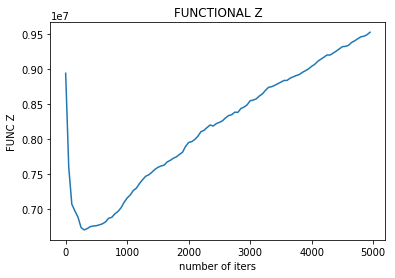

In [45]:
t=np.array(SOM.funq_history)#[2:500]
t.shape
fig = plt.figure()
plt.title('FUNCTIONAL Z')
plt.ylabel('FUNC Z')
plt.xlabel('number of iters')
x=np.arange(len(t))*50
plt.plot(x, t)

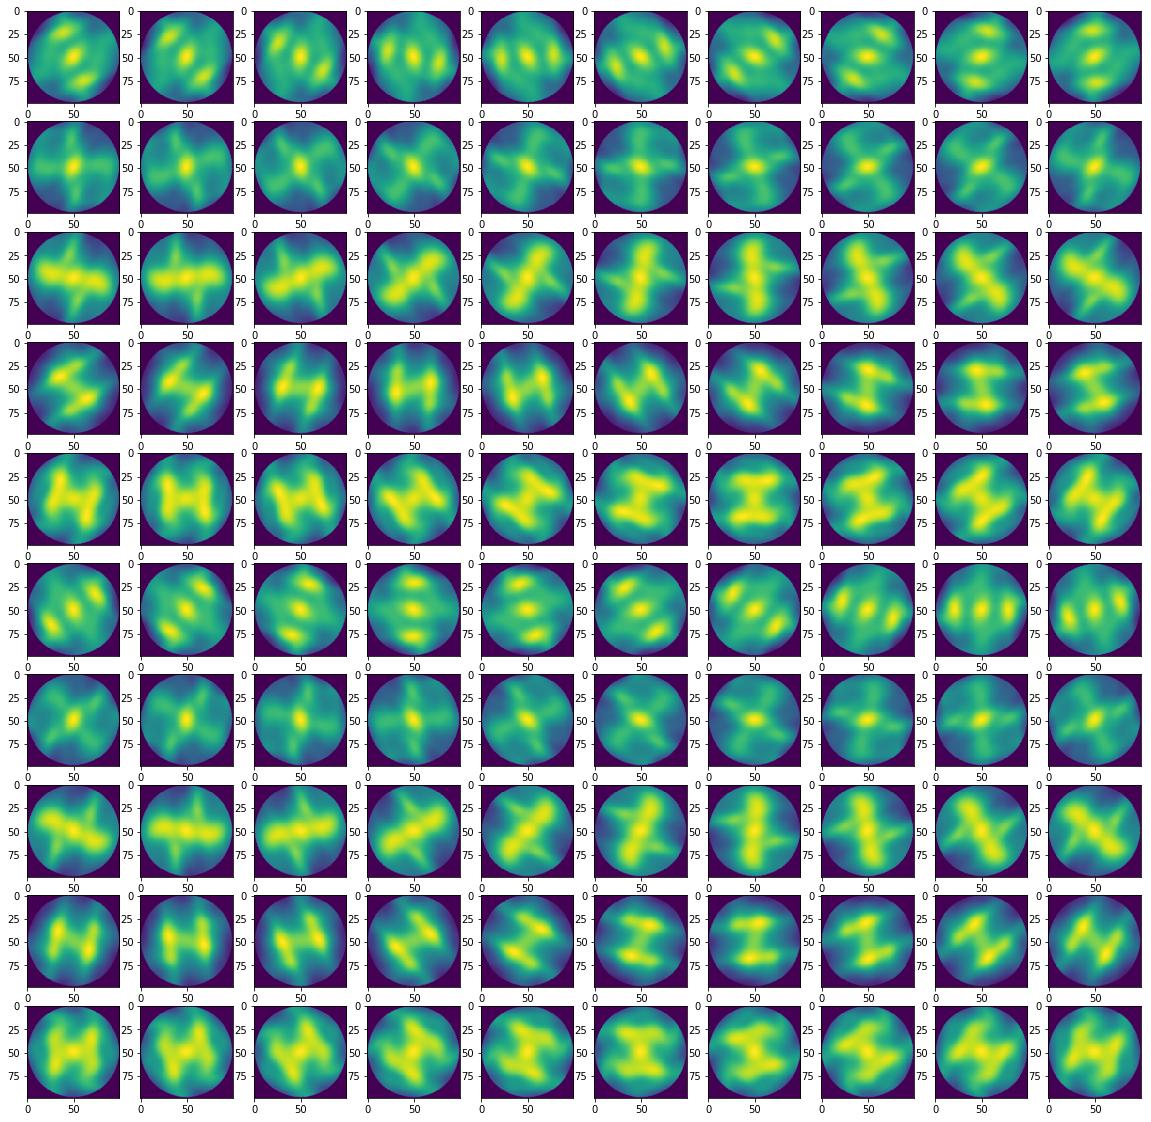

In [7]:
num=10
multipl = 6
plt.figure(figsize=(20,20))
#TST = std.inverse_transform(SOM_MAP)
TST = SOM_MAP
#TST = DATA
test=TST.reshape(multipl*num,multipl*num,-1)
for i in range(num):
    for j in range(num):
        plt.subplot(num,num,i*num+j+1)
        plt.imshow(test[multipl*i,multipl*j].reshape(99,99))

In [9]:
num=10
#TST = std.inverse_transform(SOM_MAP)
TST = SOM_MAP
test_data=TST.reshape(60,60,99,99)
@interact(x=(0,60,1),y=(0,60,1))
def test(x=30,y=0):
    plt.figure(figsize=(20,4))
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25, wspace=0.35)
    plt.axis('off')
    plt.tight_layout()
    num_plot=1
    for j in range(num):
        plt.subplot(2,num,j+1)
        plt.imshow(test_data[j+x,0])
    for i in range(num):
        plt.subplot(2,num,num+i+1)
        plt.imshow(test_data[21,i+y])
    #plt.show()

interactive(children=(IntSlider(value=30, description='x', max=60), IntSlider(value=0, description='y', max=60…

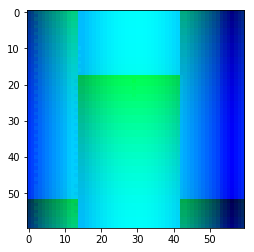

In [15]:
from sklearn.neighbors import KNeighborsRegressor,RadiusNeighborsRegressor
def get_color_map2(n):
    XV, YV = np.meshgrid(np.arange(n), np.arange(n))
    res = np.stack((YV,XV), axis=-1)

    res = np.sin(res/n*np.pi).reshape(-1,2)
    img = np.hstack((np.zeros(n*n).reshape(-1,1),res))
    img=img.reshape(n,n,3)
    return img

#DATA = np.load('data_torus_60x60_2D.npy')
n=60
color = get_color_map2(n)
neighh = KNeighborsRegressor(n_neighbors=1,weights='distance')
neighh.fit(DATA.reshape(-1,99*99),color.reshape(n*n,3))

#TST = std.inverse_transform(SOM_MAP)
TST = SOM_MAP
img_map=neighh.predict(TST.reshape(60*60,-1)).reshape(60,60,-1)
plt.imshow(img_map)

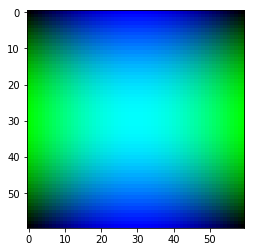

In [10]:
def get_color_map2(A,B):
    XV, YV = np.meshgrid(np.linspace(0,1,A), np.linspace(0,1,B))
    res = np.stack((YV,XV), axis=-1)
    res = np.sin(res*np.pi).reshape(-1,2)
    img = np.hstack((np.zeros(A*B).reshape(-1,1),res))
    img=img.reshape(A,B,3)
    return img
a=get_color_map2(60,60)
plt.imshow(a)

In [25]:

#SOM_MAP = SOM.SOM_MAP
#SOM_MAP_= std.inverse_transform(SOM_MAP)
np.save('SOM_weights.npy',SOM_MAP)
#np.save('SOM_history.npy',SOM.history)
#SOM_MAP=np.load('SOM_weights.npy')
#x,y,z=SOM_MAP[34:40,25].T

In [16]:
SOM_MAP = np.load('data_torus_60x60_2D.npy')
print(SOM_MAP.shape)

(3600, 3)


In [8]:
#SOM_MAP=np.load('SOM_weights.npy')
#SOM_MAP=DATA#[:1800]
#SOM_MAP = np.load('data_torus_60x60_2D.npy').reshape(60,60,3)[:30,:30]
import numpy as np
from mayavi.mlab import *
def test_plot3d():
    dd=SOM_MAP.reshape(-1,3)
    #dd=DATA
    x = dd[:,0]
    y = dd[:,1]
    z = dd[:,2]
    
    l = plot3d(x, y, z, np.arange(len(dd)), tube_radius=0.025, colormap='Spectral')
    #x,y,z=SOM_MAP[10,10]#.T
    #points3d(x,y,z,colormap="copper", scale_factor=.3)
    #return l
    axes()
test_plot3d()
show()

In [63]:
DATA = np.load('cube100x100_60x60_2D_3.npy')
#test_data=SOM_MAP.reshape(60,60,100,100)
test_data=DATA.reshape(60,60,100,100)
num=6

@interact(x=(0,60,1),y=(0,60,1))
def test(x=0,y=0):
    plt.figure(figsize=(20,20))
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25, wspace=0.35)
    plt.axis('off')
    plt.tight_layout()
    
    plt.subplot(1,2,1)
    plt.imshow(test_data[x][y])
    
    plt.subplot(1,2,2)
    plt.imshow(test_data[x+30][y])

interactive(children=(IntSlider(value=0, description='x', max=60), IntSlider(value=0, description='y', max=60)…

In [91]:
test_dataa=DATA.reshape(60,60,-1)
a = test_dataa[5,8].reshape(100,100)

b= np.flip(a,0).reshape(-1)
c=np.flip(a,1).reshape(-1)
print(a.max())
distances =np.linalg.norm(test_dataa-c,axis=-1)
index=np.unravel_index(np.argmin(distances),(60,60))
print(index)

350.18618031735264
(35, 8)


In [94]:
aa = test_dataa[35,8]
print((aa-c).max())

137.07380843440185


157.16260335097346

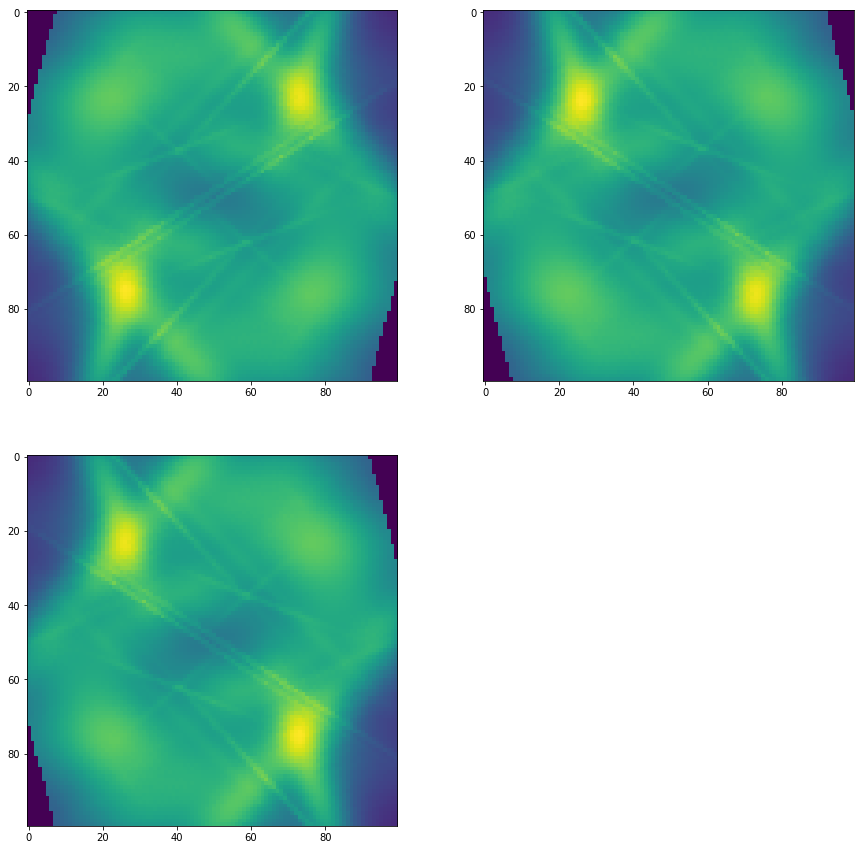

In [65]:
a = test_data[6,8]
b= np.flip(a,0)
c=np.flip(a,1)
np.flip(a,0)
plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
plt.imshow(a)
    
plt.subplot(2,2,2)
plt.imshow(b)
plt.subplot(2,2,3)
plt.imshow(c)

tst = b-c
tst.max()

In [42]:
#DATA = np.load('cube100x100_60x60_2D_3.npy')
test_data=SOM_MAP.reshape(60,60,100,100)
#test_data=DATA.reshape(60,60,100,100)
num=6

@interact(x=(0,60,1),y=(0,60,1))
def test(x=0,y=0):
    plt.figure(figsize=(20,20))
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25, wspace=0.35)
    plt.axis('off')
    plt.tight_layout()
    num_plot=1
    for i in range(int(4)):
        for j in range(int(4)):
            plt.subplot(num,num,i*num+j+1)
            plt.imshow(test_data[i+x][j+y])

interactive(children=(IntSlider(value=0, description='x', max=60), IntSlider(value=0, description='y', max=60)…

In [76]:
import numpy
from mayavi.mlab import *

def test_points3d():
    dd=SOM_MAP.reshape(-1,3)
    x = dd[:,0]
    y = dd[:,1]
    z = dd[:,2]

    return points3d(x, y, z, colormap="copper", scale_factor=.1)

test_points3d()
show()

In [71]:
@interact(i=(0,29,1))
def print_circle(i=0):
    plt.figure(figsize=(4,4))
    x = SOM_MAP[:,i,0]
    y = SOM_MAP[:,i,1]
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.plot(x,y,'o-')

interactive(children=(IntSlider(value=0, description='i', max=29), Output()), _dom_classes=('widget-interact',…

In [64]:
@interact(x=(0,29,1), y=(0,29,1))
def test(x=0,y=0):
    plt.imshow(SOM_MAP[x,y].reshape(100,100))

interactive(children=(IntSlider(value=0, description='x', max=29), IntSlider(value=0, description='y', max=29)…

In [3]:
from sklearn.neighbors import KNeighborsRegressor,RadiusNeighborsRegressor
def get_color_map2(n):
    XV, YV = np.meshgrid(np.arange(n), np.arange(n))
    res = np.stack((YV,XV), axis=-1)

    res = np.sin(res/n*np.pi).reshape(-1,2)
    img = np.hstack((np.zeros(n*n).reshape(-1,1),res))
    img=img.reshape(n,n,3)
    return img

DATA = np.load('data_torus_60x60_2D.npy')
n=60
color = get_color_map2(n)
neighh = KNeighborsRegressor(n_neighbors=1,weights='distance')
neighh.fit(DATA.reshape(n*n,-1),color.reshape(n*n,-1))

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=1, p=2,
          weights='distance')

In [5]:
def _iterator():
    for learn_rate in [0.1,0.5,1]:
        for sigma in np.linspace(0.2, 1, 3):
            for tau1 in np.linspace(1000, 20000, 4):
                for tau2 in np.linspace(1100, 20000, 5):
                    yield (np.array([learn_rate, sigma, tau1, tau2]))
        
def worker(x):
    learn_rate, sigma, tau1, tau2 = x
    SOM.change_params(sigma=sigma,learning_rate=learn_rate,tau1=tau1,tau2=tau2)
    iters, funq = SOM.training(DATA, 30000)
    SOM_MAP = SOM.SOM_MAP
    img_map=neighh.predict(SOM_MAP.reshape(60*60,-1)).reshape(n,n,-1)
    np.save('SOM_MAP.npy',SOM_MAP)
    plt.imsave(f'logs/{learn_rate:1.2f}_{sigma:1.2f}_{int(tau1)}_{int(tau2)}_{int(funq)}.png',img_map)
    res = [learn_rate, sigma, tau1, tau2, iters, funq]
    #print(f'{res}, time {Time_exec}')
    return res


DATA = np.load('data_torus_60x60_2D.npy')
np.set_printoptions(precision=2)
SOM = SOMNetwork(x=60,y=60,dim=len(DATA[0]),sigma=2,learning_rate=1,tau1=2000,tau2=100,dtype=tf.float32)
testing_params = []
for num_iter,x in enumerate(_iterator()):
    time_start = time()
    res = worker(x)
    Time_exec = time()-time_start
    print(f'iter {num_iter}, res {res},time {Time_exec}')
    testing_params.append(res)
    if num_iter %10==0:
        np.save('testing_params2.npy',np.array(testing_params))
np.save('testing_params2.npy',np.array(testing_params))

iter 0, res [0.1, 0.2, 1000.0, 1100.0, 29999, 4209.6353],time 30.705785751342773
iter 1, res [0.1, 0.2, 1000.0, 5825.0, 29999, 2403.3535],time 30.435570240020752
iter 2, res [0.1, 0.2, 1000.0, 10550.0, 29999, 1821.6401],time 30.709839820861816
iter 3, res [0.1, 0.2, 1000.0, 15275.0, 29999, 1670.5803],time 30.4798800945282
iter 4, res [0.1, 0.2, 1000.0, 20000.0, 29999, 1559.0032],time 30.91924738883972
iter 5, res [0.1, 0.2, 7333.333333333333, 1100.0, 29999, 3787.5742],time 30.827012062072754
iter 6, res [0.1, 0.2, 7333.333333333333, 5825.0, 29999, 1473.85],time 31.733603477478027
iter 7, res [0.1, 0.2, 7333.333333333333, 10550.0, 29999, 1635.7572],time 31.465835571289062
iter 8, res [0.1, 0.2, 7333.333333333333, 15275.0, 29999, 1604.7454],time 29.609227657318115
iter 9, res [0.1, 0.2, 7333.333333333333, 20000.0, 29999, 1514.304],time 29.897468328475952
iter 10, res [0.1, 0.2, 13666.666666666666, 1100.0, 29999, 3606.92],time 29.85707950592041
iter 11, res [0.1, 0.2, 13666.666666666666, 

iter 89, res [0.5, 0.6000000000000001, 7333.333333333333, 20000.0, 29999, 993.00806],time 32.78163433074951
iter 90, res [0.5, 0.6000000000000001, 13666.666666666666, 1100.0, 29999, 1122.9397],time 32.65663957595825
iter 91, res [0.5, 0.6000000000000001, 13666.666666666666, 5825.0, 29999, 1089.9591],time 31.746976375579834
iter 92, res [0.5, 0.6000000000000001, 13666.666666666666, 10550.0, 29999, 1071.739],time 33.001359701156616
iter 93, res [0.5, 0.6000000000000001, 13666.666666666666, 15275.0, 29999, 1050.5234],time 32.76476788520813
iter 94, res [0.5, 0.6000000000000001, 13666.666666666666, 20000.0, 29999, 1032.322],time 33.68706464767456
iter 95, res [0.5, 0.6000000000000001, 20000.0, 1100.0, 29999, 1138.3911],time 33.34707236289978
iter 96, res [0.5, 0.6000000000000001, 20000.0, 5825.0, 29999, 1095.3967],time 33.147183656692505
iter 97, res [0.5, 0.6000000000000001, 20000.0, 10550.0, 29999, 1081.3253],time 31.169135808944702
iter 98, res [0.5, 0.6000000000000001, 20000.0, 15275.0

iter 177, res [1.0, 1.0, 20000.0, 10550.0, 29999, 1083.6841],time 33.72304058074951
iter 178, res [1.0, 1.0, 20000.0, 15275.0, 29999, 1023.3373],time 33.67790365219116
iter 179, res [1.0, 1.0, 20000.0, 20000.0, 29999, 926.4048],time 33.175952196121216


In [16]:
a=np.load('testing_params1.npy')
ind = np.where(a[:,5]>135000)
a=a[ind]
ind = np.where(a[:,5]<150000)
a=a[ind]
ind = np.where(a[:,4]<1000)
print(ind)
print(a[ind])

(array([  2,  11,  34,  61,  73,  78,  85, 100, 108, 122, 137, 142, 149,
       156, 163, 178, 185, 192, 198, 204], dtype=int64),)
[[1.00000000e+00 6.00000000e+00 4.22222222e+02 1.00000000e+02
  8.50000000e+02 1.45321922e+05]
 [1.00000000e+00 6.00000000e+00 7.44444444e+02 1.00000000e+02
  8.50000000e+02 1.44185438e+05]
 [1.00000000e+00 6.00000000e+00 1.71111111e+03 1.00000000e+02
  7.00000000e+02 1.44024766e+05]
 [1.00000000e+00 6.00000000e+00 3.00000000e+03 1.00000000e+02
  5.50000000e+02 1.41588531e+05]
 [1.00000000e+00 7.55555556e+00 4.22222222e+02 1.00000000e+02
  8.00000000e+02 1.44922344e+05]
 [1.00000000e+00 7.55555556e+00 7.44444444e+02 1.00000000e+02
  6.00000000e+02 1.42638297e+05]
 [1.00000000e+00 7.55555556e+00 1.06666667e+03 1.00000000e+02
  7.00000000e+02 1.44515531e+05]
 [1.00000000e+00 7.55555556e+00 1.71111111e+03 1.00000000e+02
  6.00000000e+02 1.47580906e+05]
 [1.00000000e+00 7.55555556e+00 2.03333333e+03 1.00000000e+02
  5.00000000e+02 1.43369109e+05]
 [1.00000000e+

In [40]:
df = pd.DataFrame(testing_params)
df.columns = ['learn_rate', 'sigma', 'tau1', 'tau2', 'iters', 'funq']

df.loc[(df['funq']<1200) & (df['funq']>1100)]

,learn_rate,sigma,tau1,tau2,iters,funq
30,0.1,0.6,13666.666667,1100.0,29999,1179.132568
35,0.1,0.6,20000.000000,1100.0,29999,1134.959229
50,0.1,1.0,13666.666667,1100.0,29999,1102.507568
55,0.1,1.0,20000.000000,1100.0,29999,1137.089844
68,0.5,0.2,7333.333333,15275.0,29999,1164.302612
69,0.5,0.2,7333.333333,20000.0,29999,1152.225830
73,0.5,0.2,13666.666667,15275.0,29999,1184.499023
74,0.5,0.2,13666.666667,20000.0,29999,1171.935669
79,0.5,0.2,20000.000000,20000.0,29999,1179.986328
90,0.5,0.6,13666.666667,1100.0,29999,1122.939697


In [22]:
a=10
a<15 and a>9

True

INFO:tensorflow:Summary name Learning rate is illegal; using Learning_rate instead.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


iter: 0
iter: 1000
iter: 2000
iter: 3000
iter: 4000
iter: 5000
iter: 6000
iter: 7000
iter: 8000
iter: 9000
iter: 10000
iter: 11000
iter: 12000
iter: 13000
iter: 14000
iter: 15000
iter: 16000
iter: 17000
iter: 18000
iter: 19000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


22.28634023666382


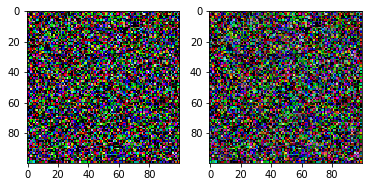

In [3]:
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt     

class SOMNetwork():
	def __init__(self, input_dim, dim=10, sigma=None, learning_rate=0.1, tay2=1000, dtype=tf.float32):
		if not sigma:
			sigma = dim / 2
		self.dtype = dtype
		#constants
		self.dim = tf.constant(dim, dtype=tf.int64)
		self.learning_rate = tf.constant(learning_rate, dtype=dtype, name='learning_rate')
		self.sigma = tf.constant(sigma, dtype=dtype, name='sigma')
		self.tay1 = tf.constant(1000/np.log(sigma), dtype=dtype, name='tay1')
		self.minsigma = tf.constant(sigma * np.exp(-1000/(1000/np.log(sigma))), dtype=dtype, name='min_sigma')
		self.tay2 = tf.constant(tay2, dtype=dtype, name='tay2')
		#input vector
		self.x = tf.placeholder(shape=[input_dim], dtype=dtype, name='input')
		#iteration number
		self.n = tf.placeholder(dtype=dtype, name='iteration')
		#variables
		self.w = tf.Variable(tf.random_uniform([dim*dim, input_dim], minval=-1, maxval=1, dtype=dtype),
			dtype=dtype, name='weights')
		#helper
		self.positions = tf.where(tf.fill([dim, dim], True))



	def training_op(self):
		win_index = self.__competition('train_')
		with tf.name_scope('cooperation') as scope:
			coop_dist = tf.sqrt(tf.reduce_sum(tf.square(tf.cast(self.positions -
				[win_index//self.dim, win_index-win_index//self.dim*self.dim], 
				dtype=self.dtype)), axis=1))
			sigma = tf.cond(self.n > 1000, lambda: self.minsigma, lambda: self.sigma * tf.exp(-self.n/self.tay1))
			sigma_summary = tf.summary.scalar('Sigma', sigma)
			tnh = tf.exp(-tf.square(coop_dist) / (2 * tf.square(sigma))) # topological neighbourhood
		with tf.name_scope('adaptation') as scope:
			lr = self.learning_rate * tf.exp(-self.n/self.tay2)
			minlr = tf.constant(0.01, dtype=self.dtype, name='min_learning_rate')
			lr = tf.cond(lr <= minlr, lambda: minlr, lambda: lr)
			lr_summary = tf.summary.scalar('Learning rate', lr)
			delta = tf.transpose(lr * tnh * tf.transpose(self.x - self.w))
			training_op = tf.assign(self.w, self.w + delta)
		return training_op, lr_summary, sigma_summary

	def __competition(self, info=''):
		with tf.name_scope(info+'competition') as scope:
			distance = tf.sqrt(tf.reduce_sum(tf.square(self.x - self.w), axis=1))
		return tf.argmin(distance, axis=0)

#== Test SOM Network ==

def test_som_with_color_data():
	som_dim = 100
	som = SOMNetwork(input_dim=3, dim=som_dim, dtype=tf.float64, sigma=3)
	test_data = np.random.uniform(0, 1, (20000, 3))
	training_op, lr_summary, sigma_summary = som.training_op()
	init = tf.global_variables_initializer()
	writer = tf.summary.FileWriter('./logs/', tf.get_default_graph())
	with tf.Session() as sess:
		init.run()
		img1 = tf.reshape(som.w, [som_dim,som_dim,-1]).eval()
		plt.figure(1)
		plt.subplot(121)
		plt.imshow(img1)
		start = time.time()
		for i, color_data in enumerate(test_data):
			if i % 1000 == 0:
				print('iter:', i)
			sess.run(training_op, feed_dict={som.x: color_data, som.n:i})
		end = time.time()
		print(end - start)
		img2 = tf.reshape(som.w, [som_dim,som_dim,-1]).eval()
		plt.subplot(122)
		plt.imshow(img2)
	writer.close()
	plt.show()		

test_som_with_color_data()

In [2]:
def Get_Distances(y,x):
    def ring_closure(A):
        if A==1: return [0]
        a=np.arange(A)
        max_val = int(len(a)/2)
        max_ind=np.argwhere(a==max_val)[0,0]
        if len(a)%2==0:
            b=np.arange(1,a[max_ind])[::-1]
        else:
            b=np.arange(1,a[max_ind+1])[::-1]
        a[max_ind+1:]=b
        return a
    yv=ring_closure(y)
    xv=ring_closure(x)
    XV, YV = np.meshgrid(xv, yv)
    #res = np.stack((YV,XV), axis=-1)
    res = np.sqrt(XV**2+YV**2)
    return res

In [5]:
a=np.ones((x*y,5))*np.array([1,2,3,4,5])

In [137]:
import tensorflow as tf
import numpy as np
 
class SOM(object):
    def __init__(self, x, y, input_dim, learning_rate, radius, num_iter=111):
        
        #Initialize properties
        self._x = x
        self._y = y
        self._learning_rate = float(learning_rate)
        self._radius = float(radius)
        self._num_iter = num_iter
        self._graph = tf.Graph()
 
        #Initialize graph
        with self._graph.as_default():
            
            #Initializing variables and placeholders
            self._weights = tf.Variable(tf.random_normal([x*y, input_dim]))
            self._locations = self._generate_index_matrix(x, y)
            self._input = tf.placeholder("float", [input_dim])
            self._iter_input = tf.placeholder("float")
 
            #Calculating BMU
            input_matix = tf.stack([self._input for i in range(x*y)])
            distances = tf.sqrt(tf.reduce_sum(tf.pow(tf.subtract(self._weights, input_matix), 2), 1))
            bmu = tf.argmin(distances, 0)
            
            #Get BMU location
            mask = tf.pad(tf.reshape(bmu, [1]), np.array([[0, 1]]))
            size = tf.cast(tf.constant(np.array([1, 2])), dtype=tf.int64)
            bmu_location = tf.reshape(tf.slice(self._locations, mask, size), [2])
 
            #Calculate learning rate and radius
            decay_function = tf.subtract(1.0, tf.div(self._iter_input, self._num_iter))
            _current_learning_rate = tf.multiply(self._learning_rate, decay_function)
            _current_radius = tf.multiply(self._radius, decay_function)
 
            #Adapt learning rate to each neuron based on position
            bmu_matrix = tf.stack([bmu_location for i in range(x*y)])
            bmu_distance = tf.reduce_sum(tf.pow(tf.subtract(self._locations, bmu_matrix), 2), 1)
            neighbourhood_func = tf.exp(tf.negative(tf.div(tf.cast(bmu_distance, "float32"), tf.pow(_current_radius, 2))))
            learning_rate_matrix = tf.multiply(_current_learning_rate, neighbourhood_func)
 
            #Update all the weights
            multiplytiplier = tf.stack([tf.tile(tf.slice(
                learning_rate_matrix, np.array([i]), np.array([1])), [input_dim])
                                               for i in range(x*y)])
            delta = tf.multiply(
                multiplytiplier,
                tf.subtract(tf.stack([self._input for i in range(x*y)]), self._weights))                
                         
            new_weights = tf.add(self._weights, delta)
            self._training = tf.assign(self._weights, new_weights)                                       
 
            #Initilize session and run it
            self._sess = tf.Session()
            initialization = tf.global_variables_initializer()
            self._sess.run(initialization)
 
    def train(self, input_vects):
        for iter_no in range(self._num_iter):
            for input_vect in input_vects:
                self._sess.run(self._training,
                               feed_dict={self._input: input_vect,
                                          self._iter_input: iter_no})
 
        self._centroid_matrix = [[] for i in range(self._x)]
        self._weights_list = list(self._sess.run(self._weights))
        self._locations = list(self._sess.run(self._locations))
        for i, loc in enumerate(self._locations):
            self._centroid_matrix[loc[0]].append(self._weights_list[i])
  
    def map_input(self, input_vectors):
        return_value = []
        for vect in input_vectors:
            min_index = min([i for i in range(len(self._weights_list))],
                            key=lambda x: np.linalg.norm(vect - self._weights_list[x]))
            return_value.append(self._locations[min_index])
        return return_value
    
    def _generate_index_matrix(self, x,y):
        return tf.constant(np.array(list(self._iterator(x, y))))
    
    def _iterator(self, x, y):
        for i in range(x):
            for j in range(y):
                yield np.array([i, j])

In [ ]:
test = SOM(30,30,3,0.5,10,20000)
test.train(DATA)

In [ ]:
SOM_MAP = test._weights_list

In [37]:
# Как точки должны быть
import numpy
from mayavi.mlab import *

def test_points3d():
    x = DATA[:,0]
    y = DATA[:,1]
    z = DATA[:,2]

    return points3d(x, y, z, colormap="copper", scale_factor=.25)

test_points3d()
show()

In [61]:
#look SOM_MAP
SOM_MAP = np.load('data_torus_60x60_2D.npy')
import numpy as np
from mayavi.mlab import *
def test_plot3d():
    dd=SOM_MAP.reshape(-1,3)
    #dd=DATA
    x = dd[:,0]
    y = dd[:,1]
    z = dd[:,2]
    
    l = plot3d(x, y, z, np.arange(len(dd)), tube_radius=0.025, colormap='Spectral')
    #return l
test_plot3d()
show()

In [10]:
#animate history
import numpy as np
from mayavi import mlab

data = np.array(SOM.history)
data[np.isinf(data)] = np.nan
#data=np.load('SOM_history.npy')
data = np.swapaxes(data.reshape(len(data),3600,3),1,2)
x, y, z = data[0]
s = np.arange(len(x))

# View it.
l = mlab.plot3d(x, y, z, s, tube_radius=0.025, colormap='Spectral')
mlab.axes()
@mlab.show
@mlab.animate(delay=1000)
def anim():
    while True:
        for i in range(len(data)):
            #stdout.write(f'\r {i}')
            x, y, z = data[i]
            l.mlab_source.trait_set(x=x,y=y,z=z)
            yield
anim()
#mlab.show()

In [23]:
#видосик
import numpy as np
import mayavi.mlab as mlab
import  moviepy.editor as mpy
data=np.load('SOM_history.npy')
duration= 10 # duration of the animation in seconds (it will loop)

# MAKE A FIGURE WITH MAYAVI

fig_myv = mlab.figure(size=(520,520), bgcolor=(1,1,1))
data = np.swapaxes(data.reshape(len(data),3600,3),1,2)
x, y, z = data[-1]
s = np.arange(len(x))
# ANIMATE THE FIGURE WITH MOVIEPY, WRITE AN ANIMATED GIF
i=0
def make_frame(t):
    global i
    mlab.clf() # clear the figure (to reset the colors)
    _data=np.swapaxes(data[i].reshape(3,60,60),1,2).reshape(3,-1)
    x, y, z = _data
    i+=1
    mlab.plot3d(x, y, z, s, tube_radius=0.025, colormap='Spectral', figure=fig_myv)
    f = mlab.gcf()
    f.scene._lift()
    return mlab.screenshot(antialiased=True)

animation = mpy.VideoClip(make_frame, duration=duration)
#animation.write_videofile("wireframe.mp4", fps=20)
animation.write_gif("wireframe.gif", fps=20)
mlab.show()

MoviePy - Building file wireframe.gif with imageio.
